# CDAE

- [Collaborative Denoising Auto-Encoders for Top-N Recommender Systems](https://alicezheng.org/papers/wsdm16-cdae.pdf)

## Experiment


In [1]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Embedding, Flatten, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

In [2]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''
    if data_size == '100k':
        file = get_file('ml-100k.zip', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip')
        file_name = 'ml-100k/*'
    elif data_size == '1m':
        file = get_file('ml-1m.zip', 'http://files.grouplens.org/datasets/movielens/ml-1m.zip')
        file_name = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        file = get_file('ml-10m.zip', 'http://files.grouplens.org/datasets/movielens/ml-10m.zip')
        file_name = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        file = get_file('ml-20m.zip', 'http://files.grouplens.org/datasets/movielens/ml-20m.zip')
        file_name = 'ml-20m/ratings.csv'
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    ratings = pd.read_csv(file_name, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [3]:
ratings = load_data('1m')
ratings.head()

5922816/5917549 [==============================] - 1s 0us/step
(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1. Data Preprocessing

In [4]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}
n_user = idx_user_map.shape[0]
print(n_user)

6040


In [5]:
idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}
n_item = idx_item_map.shape[0]
print(n_item)

3706


In [6]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [7]:
ratings = Id2idx(ratings)
ratings.head(5)

,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291


In [8]:
def make_interaction(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)

In [9]:
def data_split(df: pd.DataFrame, test_size = 0.1) -> pd.DataFrame:
    timeorder = df.groupby(by = 'userId')['timestamp'].rank(method = 'first', ascending = True)
    seen_cnt = df.groupby(by = 'userId', as_index = False)['movieId'].agg('count').rename(columns = {'movieId': 'cnts'})

    df = df.merge(seen_cnt, how = 'left', on = 'userId')
    df = df.assign(timeorder = timeorder)
    df = df.assign(split_type = lambda x: np.where(x.timeorder > x.cnts * test_size, 'train', 'test')) # 시간을 기준으로 train과 valid&test 분할

    train = df[df.split_type == 'train']
    test = df[df.split_type == 'test']
    
    valid, test = train_test_split(test, test_size = 0.5, random_state = 7777)
    valid, test = map(lambda df: df[df.userId.isin(train.userId.unique()) & df.movieId.isin(train.movieId.unique())], (valid, test)) # train에 속하지 않는 user 및 movie 삭제

    train, valid, test = map(lambda df: df.reset_index(drop = True), (train, valid, test))
    train, valid, test = map(lambda df: df.drop(columns = ['cnts', 'timeorder', 'split_type']), (train, valid, test))

    return train, valid, test

In [16]:
def make_generator(df: pd.DataFrame,
                   n_item: int,
                   batch_size: int,
                   implicit = False,
                   threshold = 3.5,
                   user_specific = True,
                   negative_sampling = 5) -> Tuple[np.array, Tuple[np.array, np.array]]:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profiles = df['movieId']
    ratings = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        np.random.shuffle(Ids)
        
        for batch_step in range(n_batch):
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch = np.zeros(shape = (batch_Id.size, n_col))
            for i, idx in enumerate(batch_Id):
                pos = profiles[idx]
                NS = len(pos) * negative_sampling
                neg = np.random.choice(np.delete(np.arange(n_col), pos), NS)
                
                batch[i, pos] = ratings[idx]
                batch[i, neg] = np.finfo(float).eps
            
            if user_specific:
                yield (batch, batch_Id), batch
            else:
                yield batch, batch

In [18]:
def masked_mae(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_ae = K.abs(mask_true * (y_true - y_pred))
    return K.sum(masked_ae, axis = -1)# / K.sum(mask_true, axis = -1)
    
def log_loss(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    ce = y_true * K.log(y_pred)
    return -K.sum(ce, axis = -1)
    
def masked_log_loss(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_ce = mask_true * y_true * K.log(y_pred)
    return -K.sum(masked_ce, axis = -1)

In [27]:
def CDAE(n_user: int,
         n_item: int, 
         latent_dim = 50,
         activation = 'linear',
         optimizer = 'adam',
         learning_rate = 0.001,
         kernel_initializer = None,
         kernel_regularizer = None,
         dropout_rate = 0.4,
         user_specific = True) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)
    if not kernel_regularizer:
        kernel_regularizer = l2(0.0001)
    
    inputs = x = Input(shape = (n_item, ), name = 'input')
    x = Dropout(dropout_rate)(x)  
    x = Dense(latent_dim, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'encoder')(x)

    if user_specific:
        users = u = Input(shape = (1, ), dtype = 'int32', name = 'user')
        u = Embedding(input_dim = n_user, output_dim = latent_dim, input_length = 1, embeddings_regularizer = kernel_regularizer)(u)
        u = Flatten()(u)
        x = concatenate([x, u], axis = 1)
    outputs = Dense(n_item, activation = 'sigmoid', kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'decoder')(x)

    if user_specific:
        model = Model(inputs = [inputs, users], outputs = outputs)
    else:
        model = Model(inputs = inputs, outputs = outputs)

    model.compile(optimizer = optimizer, loss = masked_log_loss, metrics = [masked_log_loss, masked_mae])
    return model

In [28]:
def make_predictor(df: pd.DataFrame, 
                   model: Callable, 
                   n_item: int, 
                   batch_size: int, 
                   implicit = True, 
                   threshold = 3.5,
                   user_specific = True) -> float:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profiles = df['movieId']
    ratings = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    res: float = 0.0
    N: int = 0
    steps = int(np.ceil(n_row / batch_size))
    for batch_step in range(steps):
        lower = batch_step * batch_size
        upper = lower + batch_size

        batch_Id = Ids[lower: upper]
        y_true = np.zeros(shape = (batch_Id.size, n_col))
        for i, idx in enumerate(batch_Id):
            y_true[i, profiles[idx]] = ratings[idx]

        if user_specific:
            y_pred = model.predict([y_true, batch_Id], verbose = 0)
        else:
            y_pred = model.predict(y_true, verbose = 0)

        res += np.sum(masked_log_loss(y_true, y_pred).numpy())
        N += batch_Id.size
    return res / N

In [30]:
def show_history(hist, loss: str, metric: str) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    ax1.plot(hist.history[f'{loss}'])
    ax1.plot(hist.history[f'val_{loss}'])
    ax1.set_title('Loss', fontsize = 20)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss', 'val_loss'], loc = 'upper right')

    ax2.plot(hist.history[f'{metric}'])
    ax2.plot(hist.history[f'val_{metric}'])
    ax2.set_title('Metric', fontsize = 20)
    ax2.set_ylabel('metric')
    ax2.set_xlabel('epoch')
    ax2.legend(['masked_metric', 'val_masked_metric'], loc = 'upper right')
    plt.show()

## 2. DAE

In [38]:
epochs = 500
batch_size = 128

train, valid, test = data_split(ratings)
train, valid, test = map(make_interaction, (train, valid, test))
train_gen, valid_gen = map(lambda x: make_generator(x, n_item, batch_size, implicit = True, user_specific = False), (train, valid))

steps_per_epoch = train.index.size // batch_size + 1
validation_steps = valid.index.size // batch_size + 1 

In [39]:
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
model = CDAE(n_user, n_item, latent_dim = 512, optimizer = optimizer, dropout_rate = 0.4, user_specific = False)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3706)]            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3706)              0         
_________________________________________________________________
encoder (Dense)              (None, 512)               1897984   
_________________________________________________________________
decoder (Dense)              (None, 3706)              1901178   
Total params: 3,799,162
Trainable params: 3,799,162
Non-trainable params: 0
_________________________________________________________________


In [40]:
%%time
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
model_checkpoint = ModelCheckpoint('DAE.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
48/48 [==============================] - 2s 40ms/step - loss: 12.5587 - masked_log_loss: 11.6797 - masked_mae: 480.0583 - val_loss: 1.9307 - val_masked_log_loss: 1.0743 - val_masked_mae: 30.1796
Epoch 2/500
48/48 [==============================] - 2s 37ms/step - loss: 1.3239 - masked_log_loss: 0.4789 - masked_mae: 558.8703 - val_loss: 1.6391 - val_masked_log_loss: 0.8053 - val_masked_mae: 31.7082
Epoch 3/500
48/48 [==============================] - 2s 38ms/step - loss: 1.1102 - masked_log_loss: 0.2856 - masked_mae: 564.0738 - val_loss: 1.4761 - val_masked_log_loss: 0.6612 - val_masked_mae: 32.4381
Epoch 4/500
48/48 [==============================] - 2s 41ms/step - loss: 1.0037 - masked_log_loss: 0.1979 - masked_mae: 565.8415 - val_loss: 1.3544 - val_masked_log_loss: 0.5586 - val_masked_mae: 33.3851
Epoch 5/500
48/48 [==============================] - 2s 37ms/step - loss: 0.9329 - masked_log_loss: 0.1468 - masked_mae: 566.9178 - val_loss: 1.2607 - val_masked_log_loss: 0.4853

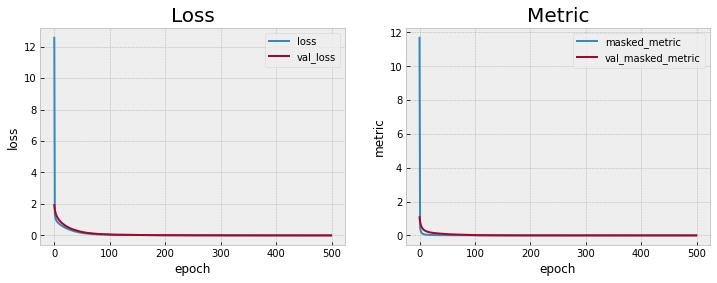

In [41]:
show_history(hist, 'loss', 'masked_log_loss')

In [42]:
test_pred = make_predictor(test, model, n_item, batch_size, user_specific = False)
print(f'Mean of masked Log Loss: {test_pred:.4f}')

Mean of masked Log Loss: 0.0007


## 3. CDAE

In [43]:
epochs = 500
batch_size = 128

train, valid, test = data_split(ratings)
train, valid, test = map(make_interaction, (train, valid, test))
train_gen, valid_gen = map(lambda x: make_generator(x, n_item, batch_size, implicit = True, user_specific = True), (train, valid))

steps_per_epoch = train.index.size // batch_size + 1
validation_steps = valid.index.size // batch_size + 1 

In [44]:
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
model = CDAE(n_user, n_item, latent_dim = 512, optimizer = optimizer, dropout_rate = 0.4, user_specific = True)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 3706)         0           input[0][0]                      
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 512)       3092480     user[0][0]                       
_______________________________________________________________________________________

In [45]:
%%time
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
model_checkpoint = ModelCheckpoint('CDAE.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


48/48 [==============================] - 3s 62ms/step - loss: 13.7139 - masked_log_loss: 12.3187 - masked_mae: 474.7740 - val_loss: 2.3285 - val_masked_log_loss: 1.0917 - val_masked_mae: 29.9677
Epoch 2/500
48/48 [==============================] - 3s 66ms/step - loss: 1.6365 - masked_log_loss: 0.4818 - masked_mae: 556.9418 - val_loss: 1.8987 - val_masked_log_loss: 0.8204 - val_masked_mae: 31.6034
Epoch 3/500
48/48 [==============================] - 3s 60ms/step - loss: 1.3162 - masked_log_loss: 0.2922 - masked_mae: 563.2619 - val_loss: 1.6474 - val_masked_log_loss: 0.6750 - val_masked_mae: 32.2944
Epoch 4/500
48/48 [==============================] - 3s 64ms/step - loss: 1.1363 - masked_log_loss: 0.2018 - masked_mae: 565.0961 - val_loss: 1.4690 - val_masked_log_loss: 0.5712 - val_masked_mae: 33.5782
Epoch 5/500
48/48 [==============================] - 3s 63ms/step - loss: 1.0200 - masked_log_loss: 0.1502 - masked_mae: 566.5919 - val_loss: 1.3423 - val_masked_log_loss: 0.5001 - val_maske

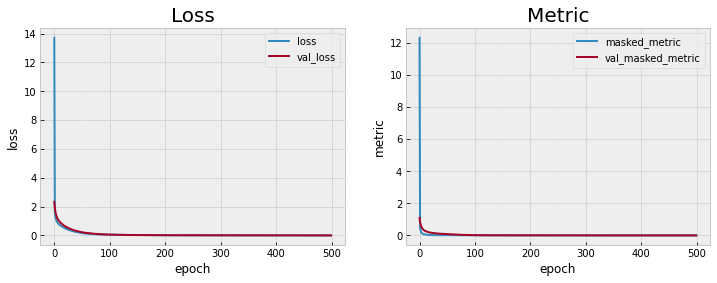

In [46]:
show_history(hist, 'loss', 'masked_log_loss')

In [47]:
test_pred = make_predictor(test, model, n_item, batch_size, user_specific = True)
print(f'Mean of masked Log Loss: {test_pred:.4f}')

Mean of masked Log Loss: 0.0007
